In [13]:
"""

Date: 20 Dec 2019

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

• Training test whether the threshold is changing
    • Create a small dataset, get outputs
    
	• Confirm proper training
	• Save after a single training loop
    To see whether the learning is "sticky" - save 
    the threshold layer after a single training loop 
    and see if it is the same as with the full loop

"""

# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Precheck on directory structure

import os
import random
import shutil

if os.listdir('data/dummy/test/cell'):
    print ("Warning! Files detected in test data directory!")
    print ("Moving files back to training data directory...")

    for f in os.listdir('data/dummy/test/cell'):
        shutil.move('data/dummy/test/cell/'+f,'data/dummy/train/cell/'+f)

    for f in os.listdir('data/dummy/test/nocell'):
        shutil.move('data/dummy/test/nocell/'+f,'data/dummy/train/nocell/'+f)
        
        
print ("Splitting all training data into 70% training and 30% test data directories...")

cell_data = os.listdir('data/dummy/train/cell')
nocell_data = os.listdir('data/dummy/train/nocell')

test_cell_data = random.sample(cell_data, int(0.3*len(cell_data)))
test_nocell_data = random.sample(nocell_data, int(0.3*len(nocell_data)))

for f in test_cell_data:
    shutil.move('data/dummy/train/cell/'+f,'data/dummy/test/cell/'+f)

for f in test_nocell_data:
    shutil.move('data/dummy/train/nocell/'+f,'data/dummy/test/nocell/'+f)

trainset = torchvision.datasets.ImageFolder(root='data/dummy/train',
                                           transform=transform)
testset = torchvision.datasets.ImageFolder(root='data/dummy/test',
                                           transform=transform)

#set size of batch and learning rate
batch_size=4
lr=0.001

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)


# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Warning! Files detected in test data directory!
Moving files back to training data directory...
Splitting all training data into 70% training and 30% test data directories...


In [14]:
class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = kernel_size
        stride = stride
        padding = padding
        dilation = dilation
        super(FlexiLayer, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)
        
        self.threshold1 = nn.parameter.Parameter(torch.randn((4, 6, 24, 24)), requires_grad=True)
        self.memorized = self.threshold1.clone()
        self.memorized_1loop = []
            
    def forward(self, t):
        
        t_1 = F.relu(F.conv2d(t, self.weight)) # get convolution result
        t_2 = F.max_pool2d(t, kernel_size=5, stride=1) # get max result with the same kernel size
        m = nn.Sigmoid()
        condmax = torch.sub(t_2, self.threshold1)
        condconv = torch.sub(t_2, self.threshold1)
        t_2 = m(condmax*50)*t_2 # 
        t_1 = m(condconv*(-50))*t_1 # 
        t = torch.add(t_2, t_1)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        return t

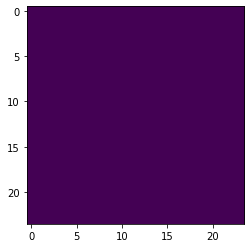

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flex1 = FlexiLayer(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=2)

    def forward(self, t):
        
        # (2) Flexible layer
        t = self.flex1(t)
        
        # (3) hidden conv layer
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 12 * 4 * 4)))
        
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        
        # (6) output layer
        t = self.out(t)
        
        return t
    
    #where function
    def where(self, cond, x_1, x_2):
        return (cond * x_1) + ((1-cond) * x_2)

net = Net()
memorized = net.flex1.memorized
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

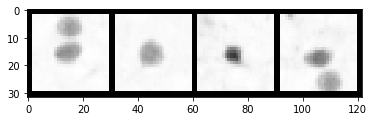

In [17]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
#writer.add_image('four_fake_images', img_grid)

In [18]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [19]:
running_loss = 0.0
for epoch in range(10):  # loop over the dataset multiple times
    
    total_loss = 0
    total_correct = 0

    for i, data in enumerate(trainloader, 0):
        
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        preds = net(inputs) # Pass batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)

        running_loss += loss.item()
            
        running_loss = 0.0
        
        if i == 1:
            net.flex1.memorized_1loop = net.flex1.threshold1

            
    print("epoch:", epoch, "loss:", total_loss)
        
print('Finished Training')

epoch: 0 loss: 106.00664794445038
epoch: 1 loss: 98.26842832565308
epoch: 2 loss: 98.64034008979797
epoch: 3 loss: 98.54122877120972
epoch: 4 loss: 98.44114303588867
epoch: 5 loss: 98.34512901306152
epoch: 6 loss: 98.24913358688354
epoch: 7 loss: 98.22079420089722
epoch: 8 loss: 98.17915630340576
epoch: 9 loss: 98.08805871009827
Finished Training


In [20]:
print(total_correct / len(trainset))

0.24285714285714285


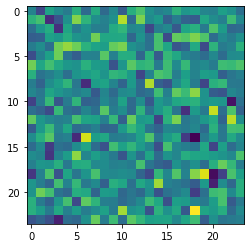

In [21]:
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:])

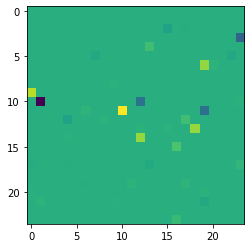

In [22]:
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])

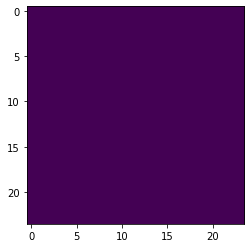

In [23]:
#Although what if it changes every time after a single small training loop - how do I check for that?

imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - net.flex1.memorized_1loop.detach().numpy()[1,1,:])